In [1]:
import tensorflow as tf
import tensorflow_probability as tfp
import numpy as np
import matplotlib.pyplot as plt

from boa.models.gpar_v2 import GPARModel
from boa.models.fully_factorized_gp_v2 import FullyFactorizedGPModel

from itertools import permutations

In [2]:
def toy_y(xs):
    """
    Toy dataset from the GPAR paper
    """
    
    xs = xs.reshape((-1, 1))
    
    def y1(x, eps_loc=0., eps_scale=0.05):
        
        eps = np.random.normal(loc=eps_loc, scale=eps_scale, size=x.shape)
        
        return -np.sin(10 * np.pi * (x + 1)) / (2 * x + 1) - x**4 + eps
    
    
    def y2(x, eps_loc=0., eps_scale=0.05):
        
        eps = np.random.normal(loc=eps_loc, scale=eps_scale, size=x.shape)
        
        return np.cos(y1(x))**2 + np.sin(3 * x) + eps
    
    
    def y3(x, eps_loc=0., eps_scale=0.05):
        
        eps = np.random.normal(loc=eps_loc, scale=eps_scale, size=x.shape)
        
        return y2(x) * y1(x)**2 + 3 * x + eps
    
    
    return np.concatenate([y1(xs), y2(xs), y3(xs)], axis=1)

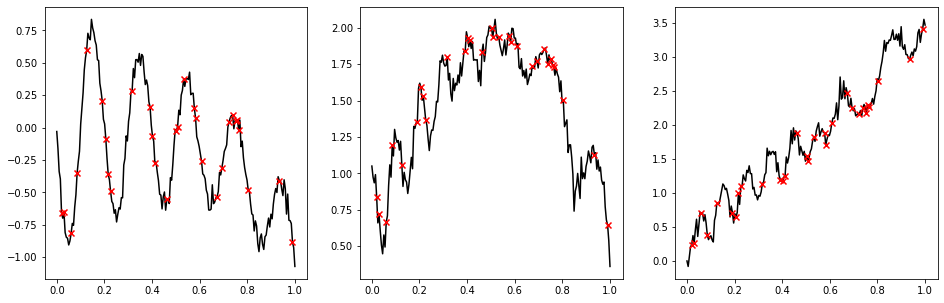

In [3]:
np.random.seed(40)

num_points = 200

xs = np.linspace(0, 1, num_points)

ys = toy_y(xs)

plt.figure(figsize=(16, 5))

train_indices = np.random.choice(num_points, 30, replace=False) 

for i in range(3):
    plt.subplot(int(f"13{i + 1}"))
    plt.plot(xs, ys[:, i], color='k', zorder=-1)
    plt.scatter(xs[train_indices], ys[train_indices, i], color='r', marker='x')

# Test the effects of various permutations of the outputs on the performance of the fully factorized GP model and GPAR

In [6]:
ff_gp.dim_length_medians

<tf.Tensor: id=306, shape=(1,), dtype=float64, numpy=array([1.00610055])>

In [4]:
perms = list(permutations(range(3)))

gps = {}

for perm in perms:
    
    gp_input = xs[train_indices].reshape((-1, 1))
    gp_output = ys[train_indices]
    gp_output = gp_output[:, perm]
    
    gpar = GPARModel(kernel="rbf", num_optimizer_restarts=5, learn_permutation=False) | (gp_input, gp_output) 
    ff_gp = FullyFactorizedGPModel(kernel="rbf", num_optimizer_restarts=5) | (gp_input, gp_output) 
    
    ff_gp.train()
    gpar.train()

    
    gps[perm] = {}
    gps[perm]["gpar"] = gpar
    gps[perm]["ff_gp"] = ff_gp

min x std: 0.2747060505768786
min y std: 0.3586386089067534
min x std: 0.2747060505768786
min y std: 0.3586386089067534
min x std: 0.2747060505768786
min y std: 0.3586386089067534
min x std: 0.2747060505768786
min y std: 0.3586386089067534
Optimization round: 1 / 5
Iteration 1 failed: cannot reshape array of size 0 into shape (1,)


ValueError: cannot reshape array of size 0 into shape (1,)

In [12]:
gps[(0, 1, 2)]['gpar'].output_perm.permutation_matrix(soft=False)

<tf.Tensor: id=4438510, shape=(3, 3), dtype=float64, numpy=
array([[0., 1., 0.],
       [0., 0., 1.],
       [1., 0., 0.]])>

In [5]:
def inv_perm(x):
    
    inv = [0] * len(x)
    
    for i in x:
        inv[x[i]] = i
        
    return tuple(inv)

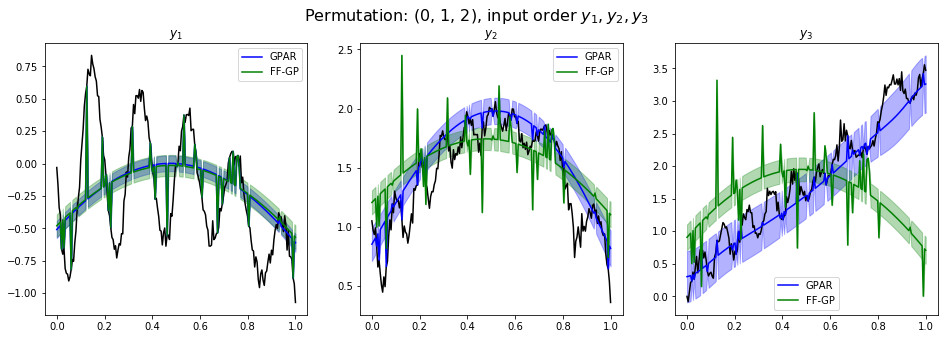

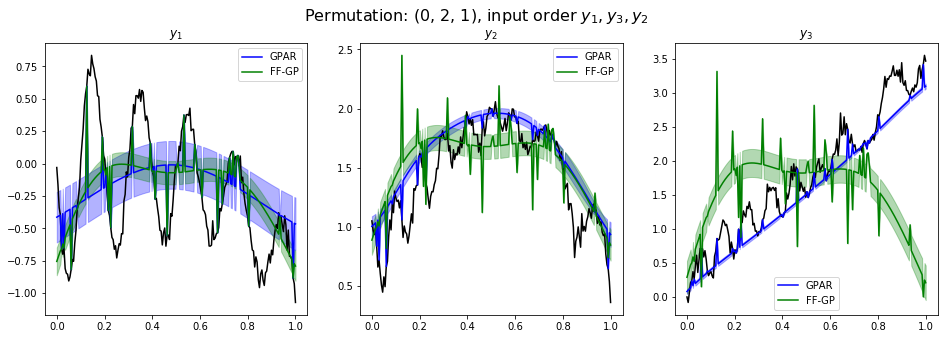

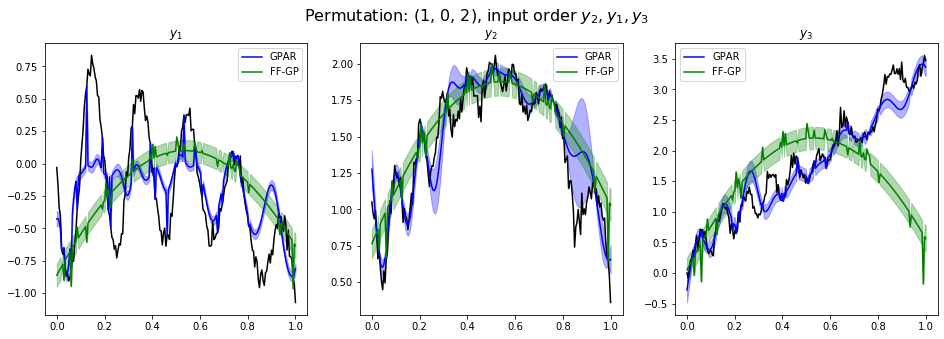

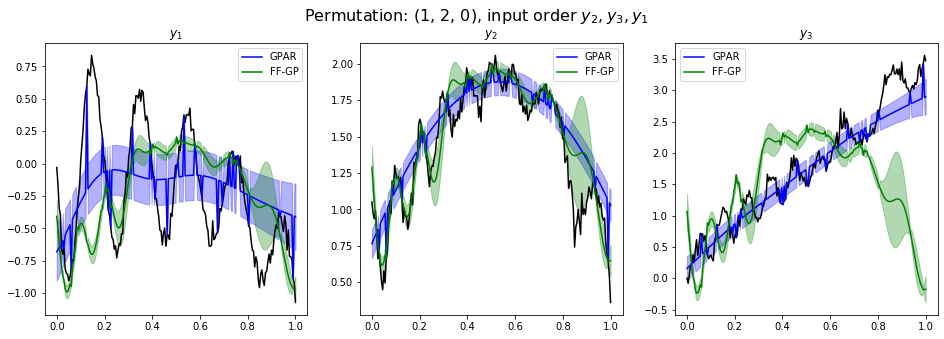

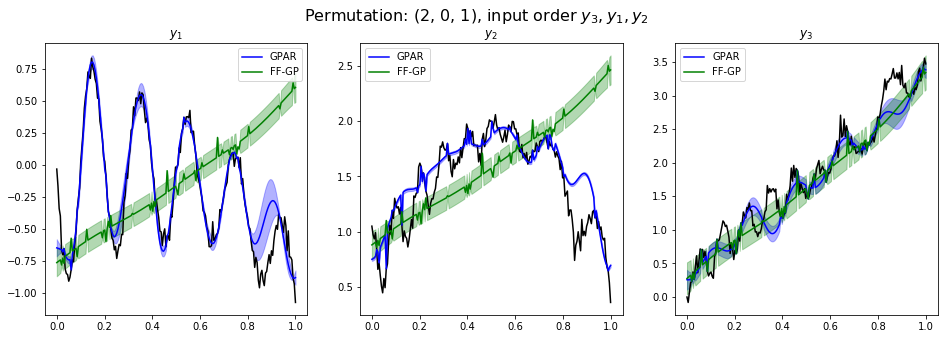

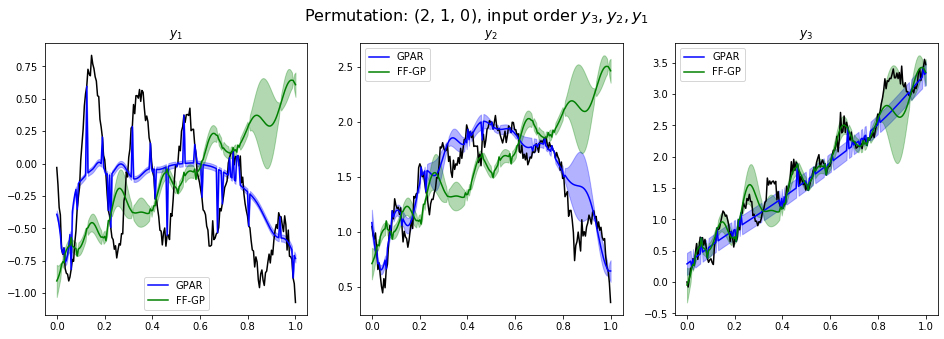

In [6]:
for k, v in gps.items():
    
    gpar = v["gpar"]
    ff_gp = v["ff_gp"]

    means, var = gpar.predict_batch(xs.reshape((-1, 1)))
    means_, var_ = ff_gp.predict_batch(xs.reshape((-1, 1)))
    
    k_inv = inv_perm(k)
    
    means = means.numpy()[:, k_inv]
    means_ = means_.numpy()[:, k_inv]
    
    var = var.numpy()[:, k_inv]
    var_ = var_.numpy()[:, k_inv]

    plt.figure(figsize=(16, 5))
    plt.suptitle(f"Permutation: {k}, input order $y_{k[0] + 1}, y_{k[1] + 1}, y_{k[2] + 1}$", fontsize=16)

    for i in range(3):
        plt.subplot(int(f"13{i + 1}"))
        plt.title(f"$y_{i + 1}$")

        plt.plot(xs, ys[:, i], color='k')

        plt.plot(xs, means[:, i], color='blue', label="GPAR")
        plt.fill_between(xs, 
                         (means[:, i] + np.sqrt(var[:, i])).T, 
                         (means[:, i] - np.sqrt(var[:, i])).T,
                         color='blue',
                         alpha=0.3,
                         zorder=-1)

        plt.plot(xs, means_[:, i], color='green', label="FF-GP")
        plt.fill_between(xs, 
                         (means_[:, i] + np.sqrt(var_[:, i])).T, 
                         (means_[:, i] - np.sqrt(var_[:, i])).T,
                         color='green',
                         alpha=0.3,
                         zorder=-1)
    
        plt.legend()
        
    plt.show()

# Gumbel-Softmax on MNIST

In [16]:
# Create dataset
batch_size = 64

data_path = "../../../../scratch/gf332/BayesOpt/data/mnist/mnist.npz"

(x_train, _), (x_test, _) = tf.keras.datasets.mnist.load_data(path=data_path)

dataset = tf.data.Dataset.from_tensor_slices(x_train)
dataset = dataset.map(lambda x: tf.cast(x, tf.float32) / 255.)
dataset = dataset.shuffle(5000)
dataset = dataset.repeat()
dataset = dataset.batch(batch_size)

In [25]:
class GumbelSoftmax(tf.Module):
    
    def __init__(self, log_probs, name="gumbel_softmax", **kwargs):
        
        super(GumbelSoftmax, self).__init__(name=name, **kwargs)
        
        log_probs = tf.convert_to_tensor(log_probs, dtype=tf.float32)
        
        # ensure that the log-probs are one dimensional
        if len(log_probs.shape) != 1:
            raise Exception("log probabilities must be a 1-d vector!")
        
        self.log_probs = log_probs
    
    def _sample_gumbel_0_1(self, shape, eps=1e-20):
                 
        u = tf.random.uniform(minval=0., maxval=1., shape=shape, dtype=tf.float32)
        
        return -tf.math.log(-tf.math.log(u + eps))
    
    def sample(self, shape=None):
        
        if shape is None:
            shape = self.log_probs.shape
            
        else:
            shape = shape + self.log_probs.shape
            
        
        eps = self._sample_gumbel_0_1(shape)
        
        shape = shape[:-1]
        
        log_probs = tf.reshape(self.log_probs, [1] * len(shape) + [-1])
        
        log_probs = tf.tile(log_probs, shape + (1,))
        
        perturbed = log_probs + eps
        
        return perturbed

In [26]:
gs = GumbelSoftmax([1, 2, 3])

# Sinkhorn-reparametrized permutation

In [147]:
perm = PermutationVariable(n_items=5, temperature=0.3)
perm.permute(np.arange(5), soft=False)

<tf.Tensor: id=4674027, shape=(5, 1), dtype=float64, numpy=
array([[2.],
       [1.],
       [0.],
       [3.],
       [4.]])>

In [98]:
pm = perm.permutation_matrix()